In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=1)

In [3]:
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGT', motives=None, motif_length=6, 
                            sequence_length=100, n_sequences=1000, n_motives=2, p=0.2,
                           random_state=1):
    random.seed(random_state)
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
    
    sequence_length = sequence_length / len(motives)
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences

    counter=0
    seqs=[]
    for i in range(n_seq_per_motif):
        total_seq = ''
        total_binary_seq=''
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            total_seq += seq
        seqs.append(('ID%d'%counter,total_seq))
        counter += 1
    binary_skeleton = '0' * flanking_length + '1' * motif_length + '0' * flanking_length
    binary_seq = binary_skeleton * n_motives
    return motives, seqs, binary_seq

In [4]:
from smod_wrapper import SMoDWrapper
from meme_wrapper import Meme
from dreme_wrapper import Dreme
from sklearn.cluster import KMeans

In [5]:
def run_tool(motif_finder, scoring_criteria, pos_seqs, neg_seqs, 
             block_size, n_motives, min_motif_len, max_motif_len,
             complexity, min_score, min_freq, min_cluster_size,
             n_clusters, similarity_threshold, freq_threshold,p_value, 
             regex_th, sample_size, std_th):
    if motif_finder=='meme':
        with open('seqs.fa','w') as f_train:
            for seq in pos_seqs:
                f_train.write('>' + seq[0] + ' \n')
                f_train.write(seq[1] + '\n')

        tool =  Meme(alphabet='dna',
                     scoring_criteria = scoring_criteria,
                     minw=min_motif_len,
                     maxw=max_motif_len,
                     nmotifs=n_motives,
                     maxsize=1000000)
        tool.fit('seqs.fa')
        
    elif motif_finder=='dreme':
        with open('seqs.fa','w') as f_train:
            for seq in pos_seqs:
                f_train.write('>' + seq[0] + ' \n')
                f_train.write(seq[1] + '\n')
        
        tool = Dreme(alphabet='dna',
                     scoring_criteria=scoring_criteria,
                     mink=min_motif_len,
                     maxk=max_motif_len,
                     e_threshold=1e-09)
        tool.fit('seqs.fa')
        
    else:
        tool = SMoDWrapper(alphabet='dna',
                           scoring_criteria = scoring_criteria,
                           complexity = complexity,
                           n_clusters = n_clusters,
                           min_subarray_size = min_motif_len,
                           max_subarray_size = max_motif_len,
                           pos_block_size = block_size,
                           neg_block_size = block_size,
                           clusterer = KMeans(),
                           min_score = min_score,
                           min_freq = min_freq,
                           min_cluster_size = min_cluster_size,
                           similarity_th = similarity_threshold,
                           freq_th = freq_threshold,
                           p_value=p_value,
                           regex_th=regex_th,
                           sample_size=sample_size,
                           std_th=std_th)
        try:
            tool.fit(pos_seqs, neg_seqs)
        except:
            print
            print "No motives found by SMoD."
            tool = None
    return tool

def score_seqs(seqs, n_motives, tool):
    scores = []
    if tool is None:
        return scores
    
    for j in range(len(seqs)):
        seq_scr = []
        iters = tool.nmotifs
        for k in range(iters):
            scr=tool.score(motif_num=k+1, seq=seqs[j][1])
            seq_scr.append(scr)

        # taking average over all motives for a sequence
        if len(seq_scr) > 1:
            x = np.array(seq_scr[0])
            for l in range(1, iters):
                x = np.vstack((x, seq_scr[l]))
            seq_scr = list(np.mean(x, axis=0))
            scores.append(seq_scr)
        elif len(seq_scr) == 1:
            scores.append(np.array(seq_scr[0]))
        else:
            raise ValueError("no sequence score")
    return scores

<h1> evaluate() modified to run only SMoD </h1>

In [6]:
import numpy as np
from sklearn.metrics import roc_auc_score
def evaluate(scoring_criteria='pwm', # ['pwm','hmm']
             motives=None,
             motif_length=6,
             n_motives=2,
             sequence_length=20,
             n_sequences=130,
             perturbation_prob=0.05,
             complexity=5,
             min_score=4,
             min_freq=0.25,
             min_cluster_size=5,
             n_clusters=15,
             min_subarray_size=5,
             max_subarray_size=10,
             similarity_threshold=.9,
             freq_threshold=None,
             p_value=0.05,
             regex_th=0.3,
             sample_size=200,
             std_th=None):

    motives, pos_seqs, binary_seq = make_artificial_dataset(alphabet='ACGT',
                                                            motives=motives,
                                                            sequence_length=sequence_length,
                                                            n_sequences=n_sequences,
                                                            motif_length=motif_length,
                                                            n_motives=n_motives,
                                                            p=perturbation_prob)
    
    from eden.modifier.seq import seq_to_seq, shuffle_modifier
    neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=1, order=2)
    neg_seqs = list(neg_seqs)

    block_size=n_sequences/8

    pos_size = len(pos_seqs)
    train_pos_seqs = pos_seqs[:pos_size/2]
    test_pos_seqs = pos_seqs[pos_size/2:]

    neg_size = len(neg_seqs)
    train_neg_seqs = neg_seqs[:neg_size/2]

    test_neg_seqs = neg_seqs[neg_size/2:]

    true_score = [float(int(i)) for i in binary_seq]

    tool_result = {'smod':[],'meme':[], 'dreme':[]}
    for i in tool_result.keys():
        # MODIFICATION
        if i in ['meme', 'dreme']:
            tool_result[i].append(0.4)
            continue
        tool = run_tool(motif_finder=i,
                        scoring_criteria = scoring_criteria,
                        pos_seqs=train_pos_seqs, 
                        neg_seqs=train_neg_seqs,
                        block_size=block_size,
                        n_motives=n_motives, 
                        complexity = complexity,
                        min_motif_len=min_subarray_size,
                        max_motif_len=max_subarray_size,
                        min_score=min_score,
                        min_freq=min_freq,
                        min_cluster_size=min_cluster_size,
                        n_clusters=n_clusters,
                        similarity_threshold=similarity_threshold,
                        freq_threshold=freq_threshold,
                        p_value=p_value,
                        regex_th=regex_th,
                        sample_size=sample_size,
                        std_th=std_th)
        
        try:
            scores = score_seqs(seqs=test_pos_seqs,
                                n_motives=n_motives,
                                tool=tool)
        except:
            print "Scoring failed for ", i
            continue
        
        if not scores:
            print "No scores for ", i
            continue
        mean_score = np.mean(scores, axis=0)
        roc_score = roc_auc_score(true_score, mean_score)
        tool_result[i].append(roc_score)
    return tool_result

In [7]:
% matplotlib inline
import pylab as plt 

def plot_results(data, title='Experiment', xlabel='param', ylabel='values'):
    data_x =  np.array([param for param, val_m, val_s, val_d in data])
    data_y_m = np.array([val_m for param, val_m, val_s, val_d in data])
    data_d_m = np.array([val_m for param, val_m, val_s, val_d in data])
    data_y_s = np.array([val_s for param, val_m, val_s, val_d in data])
    data_d_s = np.array([val_s for param, val_m, val_s, val_d in data])
    data_y_d = np.array([val_d for param, val_m, val_s, val_d in data])
    data_d_d = np.array([val_d for param, val_m, val_s, val_d in data])
    
    plt.figure(figsize=(16,3))
    
    line_m, = plt.plot(data_x, data_y_m, lw=4, ls='-', color='cornflowerblue')
    plt.fill_between(data_x, data_y_m - data_d_m, data_y_m + data_d_m, alpha=0.1, color="b")
    plt.plot(data_x, data_y_m, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='cornflowerblue', markeredgewidth=3.0)
    
    line_s, = plt.plot(data_x, data_y_s, lw=4, ls='-', color='red')
    plt.fill_between(data_x, data_y_s - data_d_s, data_y_s + data_d_s, alpha=0.1, color="r")
    plt.plot(data_x, data_y_s, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='red', markeredgewidth=3.0)
    
    line_d, = plt.plot(data_x, data_y_d, lw=4, ls='-', color='green')
    plt.fill_between(data_x, data_y_d - data_d_d, data_y_d + data_d_d, alpha=0.1, color="g")
    plt.plot(data_x, data_y_d, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='green', markeredgewidth=3.0)
    
    d=10.0
    plt.xlim([min(data_x)-(max(data_x) - min(data_x))/d, max(data_x)+(max(data_x) - min(data_x))/d])
    plt.ylim(ymax=1)
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend((line_m, line_s, line_d), ('MEME', 'SMoD', 'DREME'), loc=0)
    plt.grid()
    plt.show()

In [8]:
n_rep = 10

In [9]:
smod_setting = {0.1:{'min_freq': 0.091,     # ROC= 0.785
                     'min_score': 6, 
                     'p_value': 0.11, 
                     'min_cluster_size': 3, 
                     'std_th': 0.21, 
                     'regex_th': 0.29, 
                     'similarity_th': 0.86, 
                     'freq_th': 0.062},
                0.2:{'min_freq': 0.06,    # ROC = 0.736
                     'min_score': 6, 
                     'p_value': 0.13, 
                     'min_cluster_size': 3, 
                     'std_th': 0.21, 
                     'regex_th': 0.29, 
                     'similarity_th': 0.80, 
                     'freq_th': 0.04},
                0.3:{'min_freq': 0.0878,    # ROC = 0.734
                     'min_score': 6,
                     'p_value': 0.104,
                     'min_cluster_size': 3,
                     'std_th': 0.186,
                     'regex_th': 0.297,
                     'similarity_th': 0.815,
                     'freq_th': 0.024},
                0.4:{'min_freq': 0.11,    # ROC = 0.737
                     'min_score': 6,
                     'p_value': 0.107,
                     'min_cluster_size': 3,
                     'std_th': 0.217,
                     'regex_th': 0.279,
                     'similarity_th': 0.805,
                     'freq_th': 0.0637},
                0.5:{'min_freq': 0.112,    # ROC = 0.738
                     'min_score': 6,
                     'p_value': 0.0983,
                     'min_cluster_size': 3,
                     'std_th': 0.197,
                     'regex_th': 0.291,
                     'similarity_th': 0.821,
                     'freq_th': 0.072},
                0.6:{'min_freq': 0.0866,    # ROC = 0.686
                     'min_score': 6,
                     'p_value': 0.0799,
                     'min_cluster_size': 3,
                     'std_th': 0.214,
                     'regex_th': 0.284,
                     'similarity_th': 0.815,
                     'freq_th': 0.0492},
                0.7:{'min_freq': 0.0866,    # Repeated
                     'min_score': 6,
                     'p_value': 0.0799,
                     'min_cluster_size': 3,
                     'std_th': 0.214,
                     'regex_th': 0.284,
                     'similarity_th': 0.815,
                     'freq_th': 0.0492},
                0.8:{'min_freq': 0.104,    # ROC = 0.678
                     'min_score': 6,
                     'p_value': 0.0953,
                     'min_cluster_size': 3,
                     'std_th': 0.187,
                     'regex_th': 0.296,
                     'similarity_th': 0.808,
                     'freq_th': 0.0448},
                0.9:{'min_freq': 0.104,    # Repeated
                     'min_score': 6,
                     'p_value': 0.0953,
                     'min_cluster_size': 3,
                     'std_th': 0.187,
                     'regex_th': 0.296,
                     'similarity_th': 0.808,
                     'freq_th': 0.0448},
                'default':{'min_freq': 0.69,    # ROC=0.98 with p=0.2
                           'min_score': 7, 
                           'p_value': 1,    # 0.4
                           'min_cluster_size': 1, 
                           'std_th': 0.48, 
                           'regex_th': 0.92, 
                           'similarity_th': 0.5, #0.95 
                           'freq_th': 0.69}
}

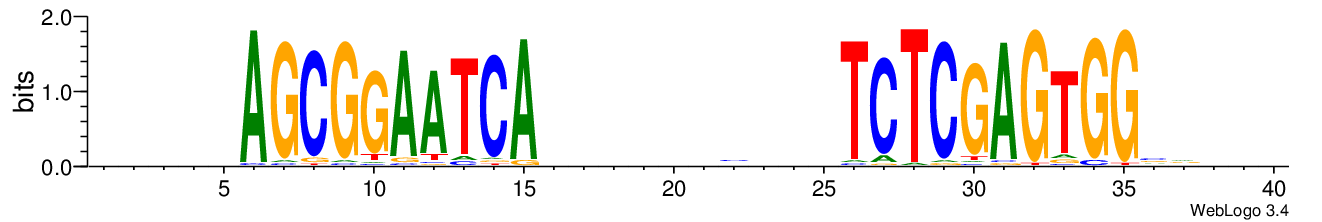

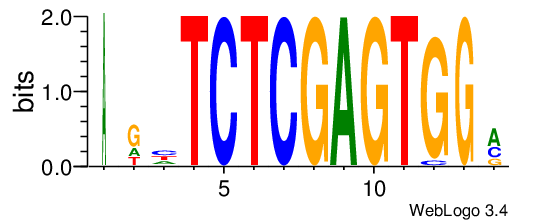

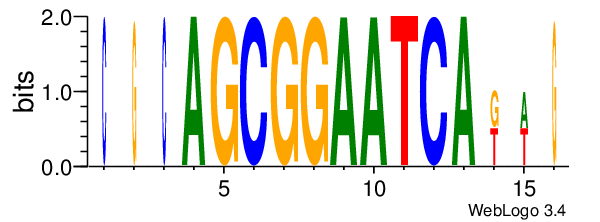

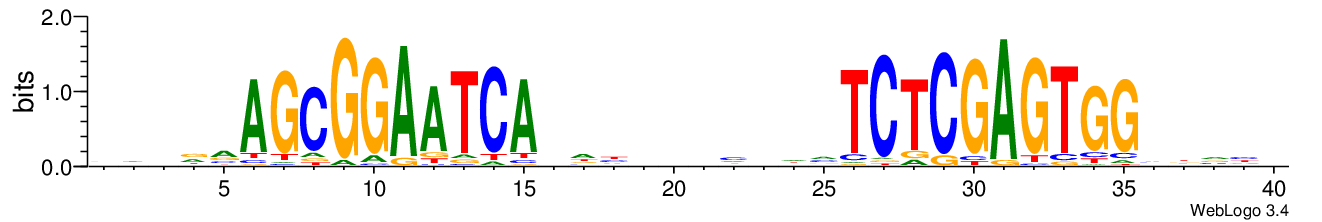

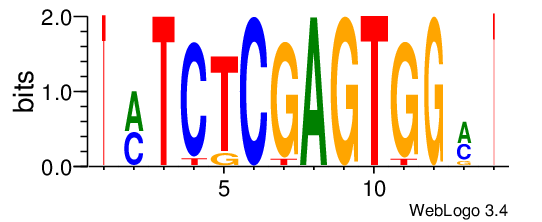

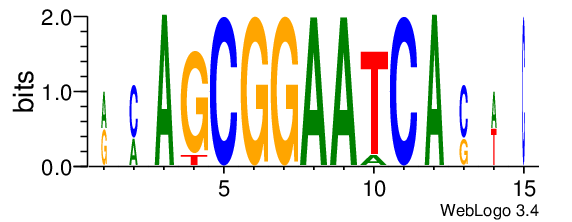

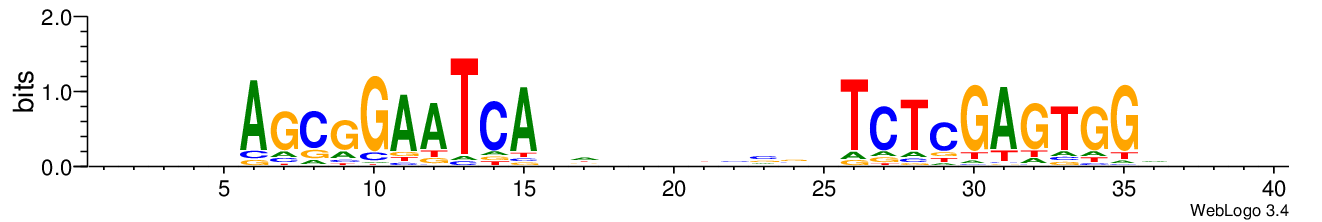

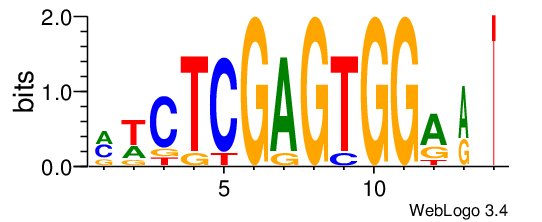

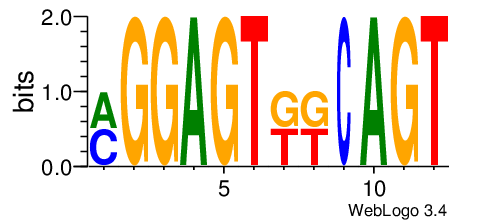

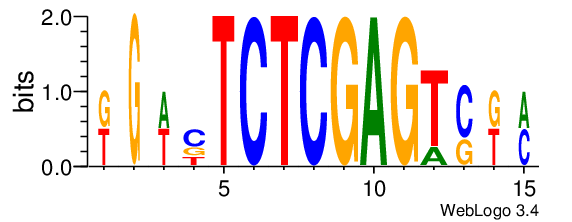

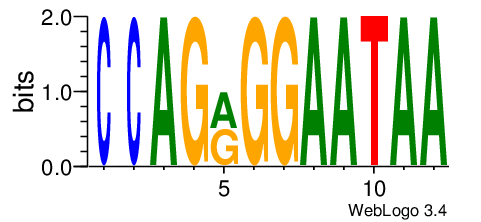

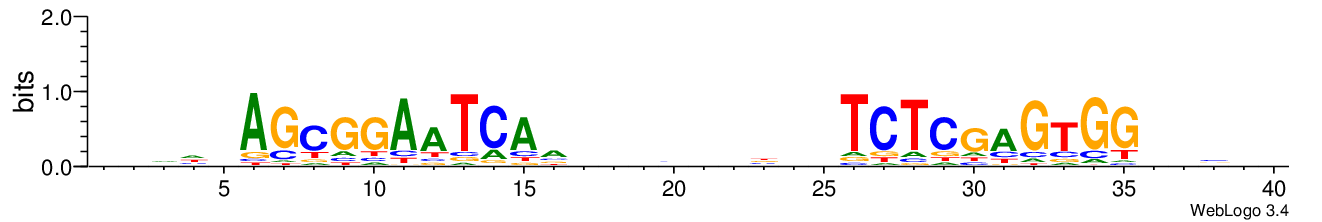

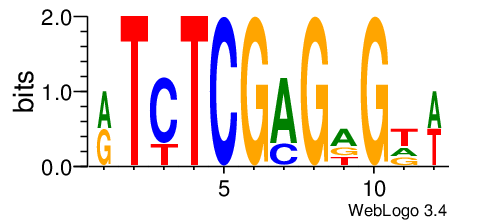

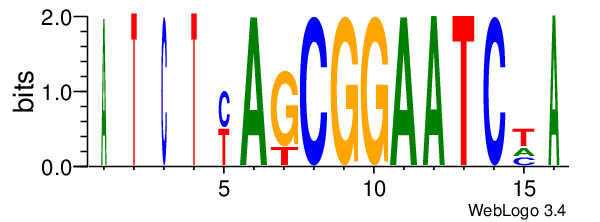

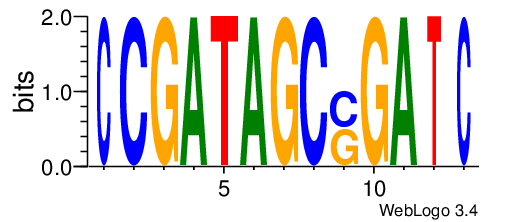

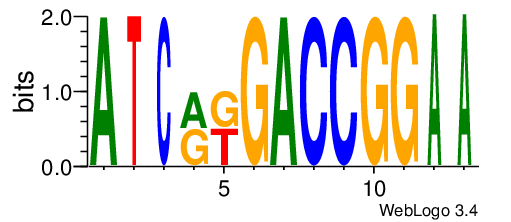

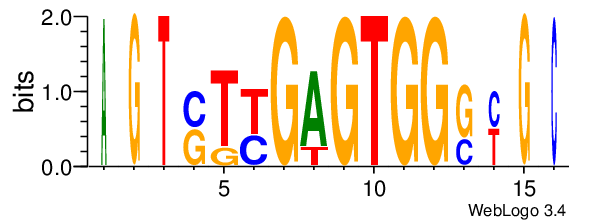

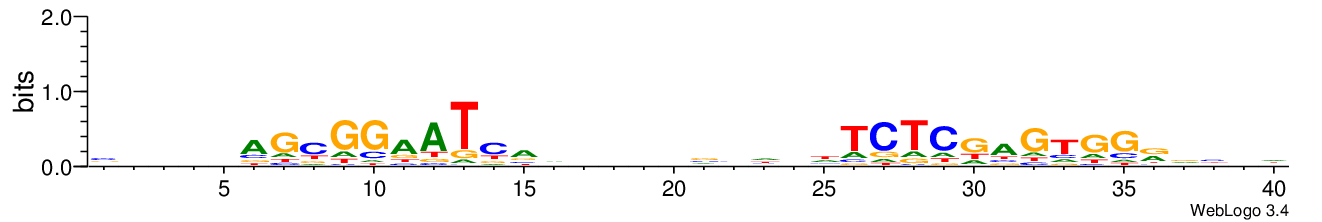

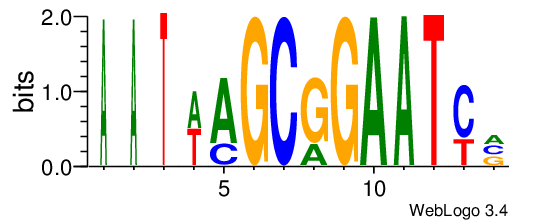

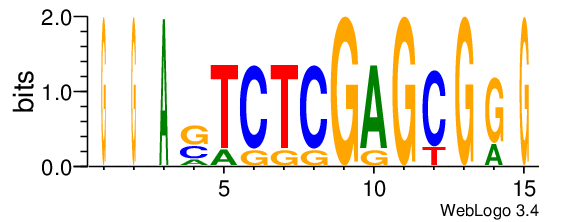

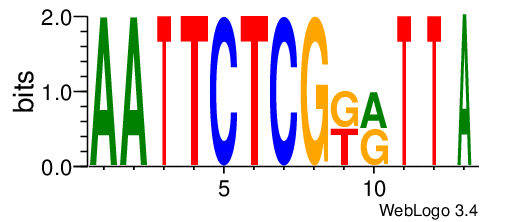

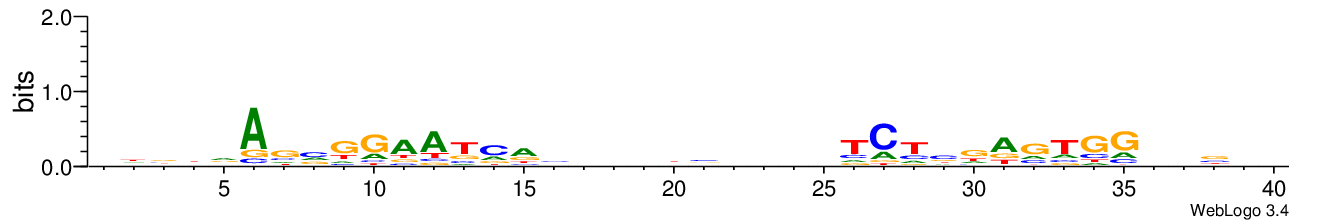

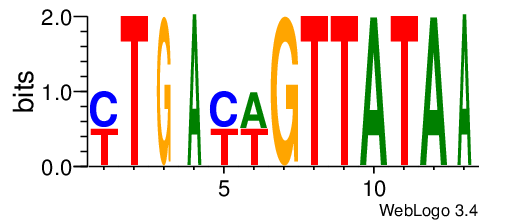

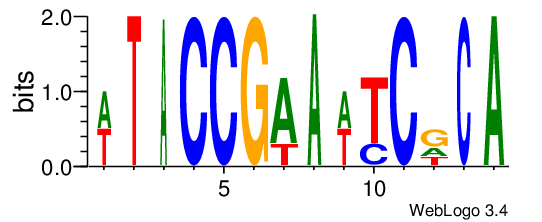

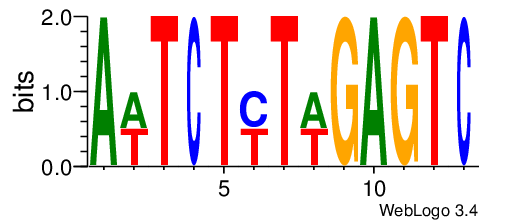

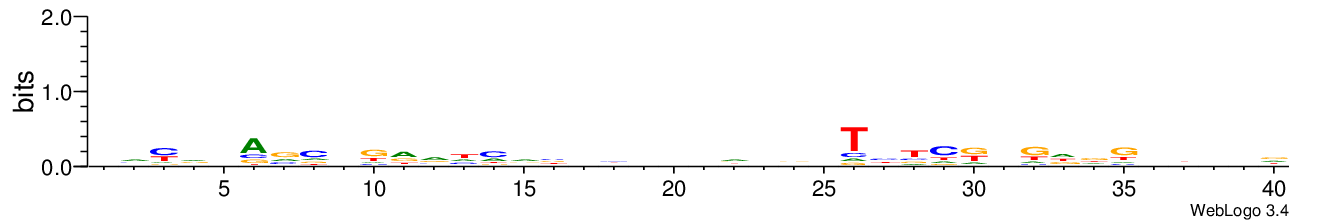

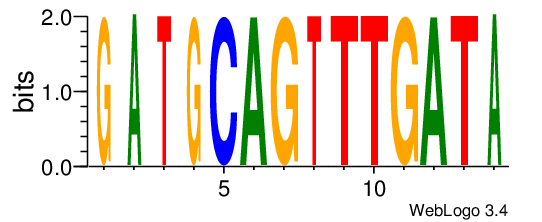

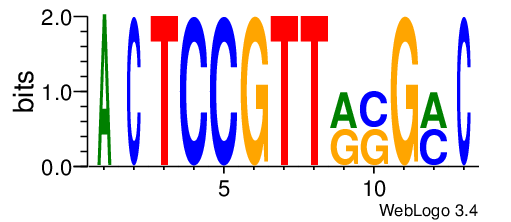

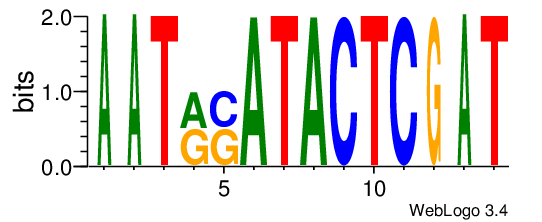

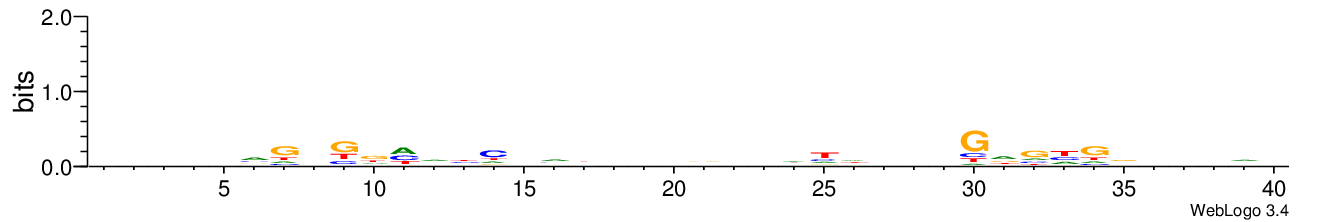

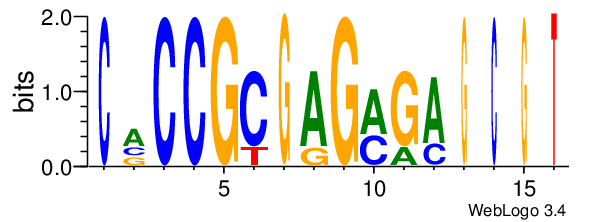

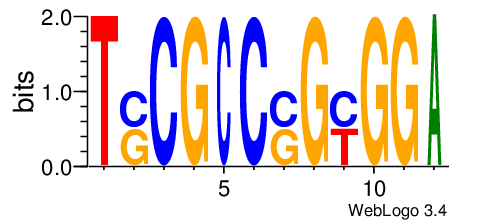

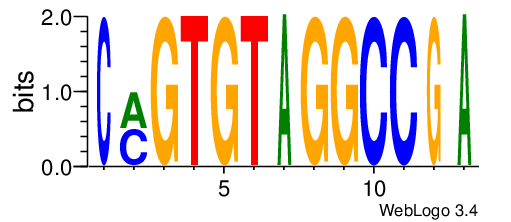

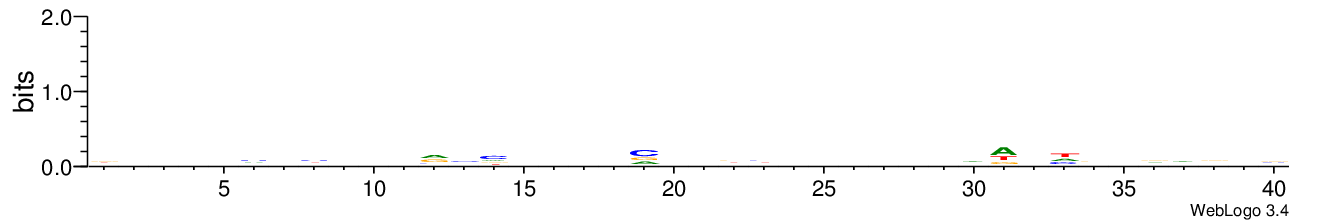


No motives found


In [36]:
for i in [x/float(10) for x in range(1,10)]:
    m,s,b = make_artificial_dataset(motif_length=10,
                                   n_motives=2,
                                   sequence_length=40,
                                   n_sequences=40,
                                   p=i,
                                   random_state=3)
    img = Weblogo(units='bits').create_logo(seqs=s)
    display(Image(img))
    print 
    try:
        smod = SMoDWrapper(scoring_criteria = 'pwm',
                               #complexity = complexity,
                               #n_clusters = n_clusters,
                               min_subarray_size = 8,
                               max_subarray_size = 12,
                               pos_block_size = 20,
                               neg_block_size = 20,
                               clusterer = KMeans(),
                               min_score = 7,
                               min_freq = 0.69,
                               min_cluster_size = 1,
                               similarity_th = 0.5,
                               freq_th = 0.69,
                               p_value=1,
                               regex_th=0.92,
                               #sample_size=sample_size,
                               std_th=0.48)
        from eden.modifier.seq import seq_to_seq, shuffle_modifier
        neg_seqs = seq_to_seq(s, modifier=shuffle_modifier, times=1, order=2)
        neg_seqs = list(neg_seqs)

        block_size=40/8

        pos_size = len(s)
        train_pos_seqs = s[:pos_size/2]
        test_pos_seqs = s[pos_size/2:]

        neg_size = len(neg_seqs)
        train_neg_seqs = neg_seqs[:neg_size/2]
        test_neg_seqs = neg_seqs[neg_size/2:]
        smod.fit(s, neg_seqs)
        smod.display_logo()
        
    except:
        print "No motives found"

/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


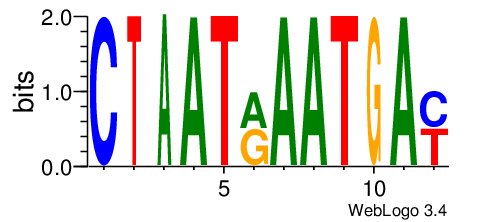

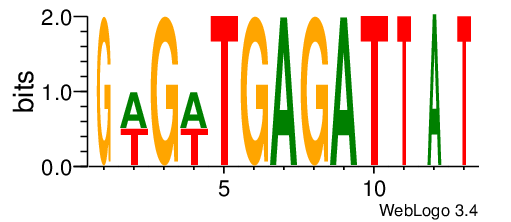

In [31]:
smod = SMoDWrapper(scoring_criteria = 'pwm',
                           #complexity = complexity,
                           #n_clusters = n_clusters,
                           min_subarray_size = 8,
                           max_subarray_size = 12,
                           pos_block_size = 20,
                           neg_block_size = 20,
                           clusterer = KMeans(),
                           min_score = 7,
                           min_freq = 0.69,
                           min_cluster_size = 1,
                           similarity_th = 0.5,
                           freq_th = 0.69,
                           p_value=1,
                           regex_th=0.92,
                           #sample_size=sample_size,
                           std_th=0.48)
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(s, modifier=shuffle_modifier, times=1, order=2)
neg_seqs = list(neg_seqs)

block_size=40/8

pos_size = len(s)
train_pos_seqs = s[:pos_size/2]
test_pos_seqs = s[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]
smod.fit(s, neg_seqs)
smod.display_logo()

In [17]:
m

['ATTCCCGTAA', 'TCTACGATTA']

In [18]:
s

[('ID0', 'AGTCACAATTCTCCTAAACCAAACCTGCGTTTCTACGATTAGGAATCA'),
 ('ID1', 'AAGTGCAATTCCCTTAAGTTGTAGTGGCATGTCAGCGATTAAGCCCGG'),
 ('ID2', 'GAAATAAATTCCCATAAGCAAGACGTAAAGATCTACGCTTAGGGATTG'),
 ('ID3', 'TCTGCCAATTCCCGTAATATTGATCCCTTAATCTACGATAACTTCAGT'),
 ('ID4', 'ATGTCCCATTCCCGTAATGTTAGAACTGTCCACTACGTTTATTAGAAT'),
 ('ID5', 'CCCAGAAATACCCGTAATCGCCATCAACTCGTCTACGAAGAGTCCCCT'),
 ('ID6', 'GCTCTAGAGTCCTCTAATATATTTTGGACAGTCTACGATCAGCATTGG'),
 ('ID7', 'CTCCGAAATTCCCGTAAGGGCGGAGTATTCGTCCACGGTTATCGGGTT'),
 ('ID8', 'AGATTGCATTCCCCTAGTTATTGGCACAGAATCTACGATTACAGGTAC'),
 ('ID9', 'TTGCCATATTCCCCTAAAGGTTTATGCGCAATCTACGATCACGTTGTC'),
 ('ID10', 'CTGGTGCATTCCCGTAAGGGGCGGGATCCAGTCTACGATTAGCCGAGT'),
 ('ID11', 'CGGAGGTATTCCTGTAACGAGATTTAGATCTTCTACGCTAGGGCGAAG'),
 ('ID12', 'TAAGTTGAATCCCGTAACTAGACCTATTCCGGCCACAACAGTCTTATA'),
 ('ID13', 'GGTGCGTATCCTCGTAAGAATGCGTCTATTTTCCACGTATAAATCCTA'),
 ('ID14', 'CATTTCCGTTCCCGTAAAGCCTTGACGACGATCTACTATTATGCCCCG'),
 ('ID15', 'TTTTAGGATTCACGTCATTGGCTGAAGCACGCCTACGATTAGAATGAT'),
 (

In [22]:
from utilities import Weblogo
from IPython.display import Image, display

In [21]:
img = Weblogo().create_logo(seqs=s)

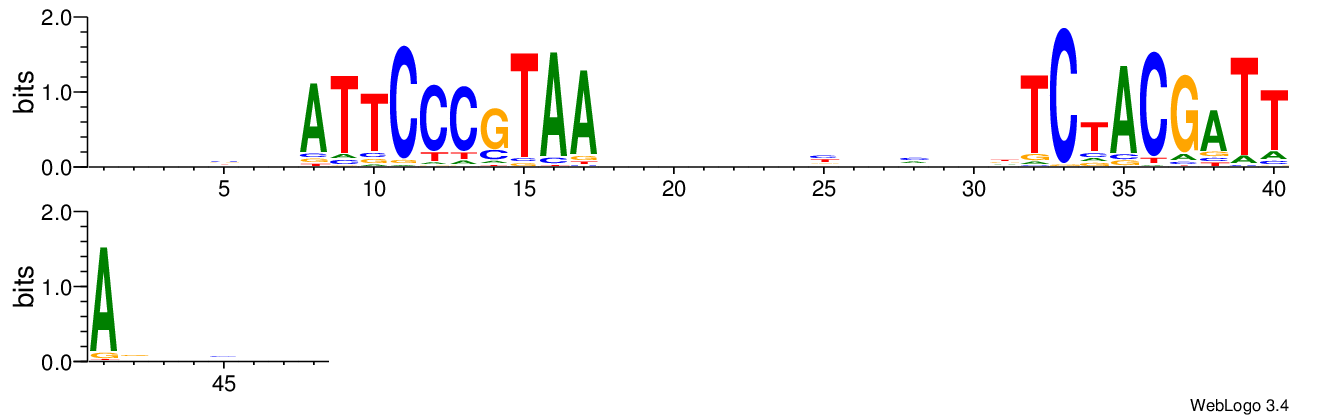

In [23]:
img = Weblogo().create_logo(seqs=s)
display(Image(img))

<h1> Running SMoD only </h1>

/home/zr/eden/EDeN/eden/sequence_motif_decomposer.py:48: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(x - a) / b))


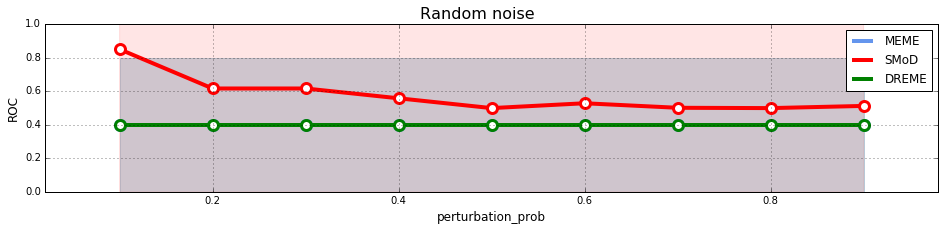

CPU times: user 13min 50s, sys: 8.1 s, total: 13min 58s
Wall time: 18min


In [10]:
%%time

def make_results(n_rep=2):
    for param in [x/float(10) for x in range(1,10)]:
        if param in smod_setting.keys():
            setting = smod_setting[param]
        else:
            setting = smod_setting['default']
            
        results = {'smod':[], 'meme':[], 'dreme':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm',
                                   motif_length=10,
                                   n_motives=4,
                                   sequence_length=300,
                                   n_sequences=500,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   p_value=setting['p_value'],
                                   similarity_threshold=setting['similarity_th'],
                                   min_score=setting['min_score'],
                                   min_freq=setting['min_freq'],
                                   min_cluster_size=setting['min_cluster_size'],
                                   regex_th=setting['regex_th'],
                                   sample_size=200,
                                   freq_threshold=setting['freq_th'],
                                   std_th=setting['std_th'])
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
            results['dreme'].append(tool_result['dreme'])
        for tool in results.keys():
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            results[tool] = avg
        yield param, results['meme'], results['smod'], results['dreme']

data = [(param, val_m, val_s, val_d) for param, val_m, val_s, val_d in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


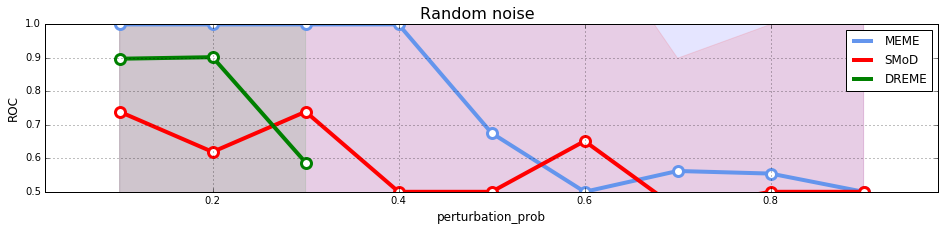

CPU times: user 9min 41s, sys: 4.76 s, total: 9min 46s
Wall time: 1h 5min 43s


In [9]:
%%time

def make_results(n_rep=1):
    for param in [x/float(10) for x in range(1,10)]:
        if param in smod_setting.keys():
            setting = smod_setting[param]
        else:
            setting = smod_setting['default']
            
        results = {'meme':[], 'smod':[], 'dreme':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm',
                                   motif_length=10,
                                   n_motives=4,
                                   sequence_length=300,
                                   n_sequences=500,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   p_value=setting['p_value'],
                                   similarity_threshold=setting['similarity_th'],
                                   min_score=setting['min_score'],
                                   min_freq=setting['min_freq'],
                                   min_cluster_size=setting['min_cluster_size'],
                                   regex_th=setting['regex_th'],
                                   sample_size=200,
                                   freq_threshold=setting['freq_th'],
                                   std_th=setting['std_th'])
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
            results['dreme'].append(tool_result['dreme'])
        for tool in ['meme', 'smod', 'dreme']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            results[tool] = avg
        yield param, results['meme'], results['smod'], results['dreme']

data = [(param, val_m, val_s, val_d) for param, val_m, val_s, val_d in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

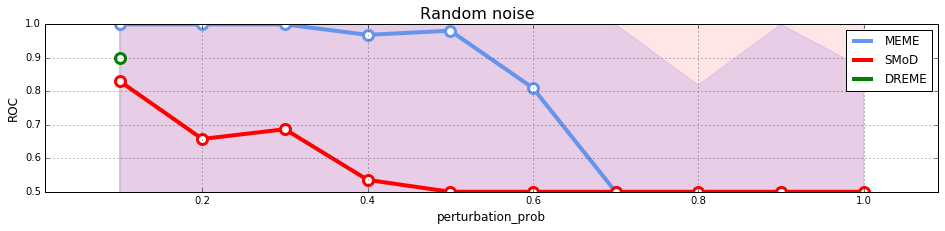

CPU times: user 3min 23s, sys: 15.8 s, total: 3min 38s
Wall time: 7min 27s


In [19]:
%%time

def make_results(n_rep=5):
    for param in [x/float(10) for x in range(1,11)]:
        if param in smod_setting.keys():
            setting = smod_setting[param]
        else:
            setting = smod_setting['default']
            
        results = {'meme':[], 'smod':[], 'dreme':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm',
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=200,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   p_value=setting['p_value'],
                                   similarity_threshold=setting['similarity_th'],
                                   min_score=setting['min_score'],
                                   min_freq=setting['min_freq'],
                                   min_cluster_size=setting['min_cluster_size'],
                                   regex_th=setting['regex_th'],
                                   sample_size=200,
                                   freq_threshold=setting['freq_th'],
                                   std_th=setting['std_th'])
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
            results['dreme'].append(tool_result['dreme'])
        for tool in ['meme', 'smod', 'dreme']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            results[tool] = avg
        yield param, results['meme'], results['smod'], results['dreme']

data = [(param, val_m, val_s, val_d) for param, val_m, val_s, val_d in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 99 pos 52

seqs=   100, min=  52, max=   52, total=     5200

motif=1
SEED WIDTHS: 8 11 12
em: w=  12, psites= 100, iter=   0 
motif=2
SEED WIDTHS: 8 11 12
em: w=  12, psites= 100, iter=   0 




No motives found by SMoD.


INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 99 pos 52

seqs=   100, min=  52, max=   52, total=     5200

motif=1
SEED WIDTHS: 8 11 12
em: w=  12, psites= 100, iter=   0 
motif=2
SEED WIDTHS: 8 11 12
em: w=  12, psites= 100, iter=   0 




No motives found by SMoD.


/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packa

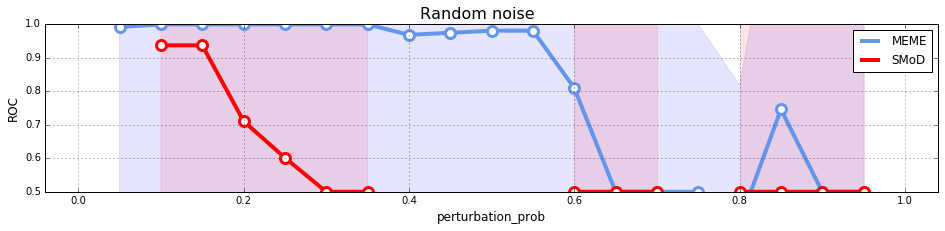

CPU times: user 2min 16s, sys: 13.7 s, total: 2min 30s
Wall time: 4min 36s


In [11]:
%%time

def make_results(n_rep=2):
    for param in [x/float(20) for x in range(1,20)]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm',
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=200,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   p_value=0.7,
                                   similarity_threshold=1.0,
                                   min_score=8,
                                   min_freq=1.0,
                                   min_cluster_size=1,
                                   regex_th=0.18,
                                   sample_size=200,
                                   freq_threshold=0.71,
                                   std_th=0.38)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.


/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filter is too strict. Ignoring filter.
Quality filte

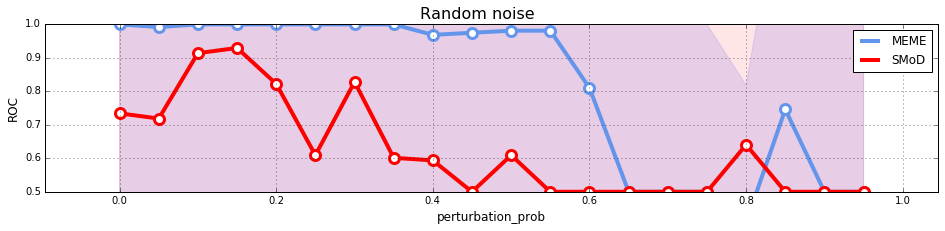

CPU times: user 2min 47s, sys: 13.1 s, total: 3min
Wall time: 5min 3s


In [9]:
%%time

def make_results(n_rep=2):
    for param in [x/float(20) for x in range(20)]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm',
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=200,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   p_value=0.2,
                                   similarity_threshold=0.89,
                                   min_score=2,
                                   min_freq=0.51,
                                   min_cluster_size=4,
                                   regex_th=0.31,
                                   sample_size=200,
                                   freq_threshold=0.59,
                                   std_th=0.24)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

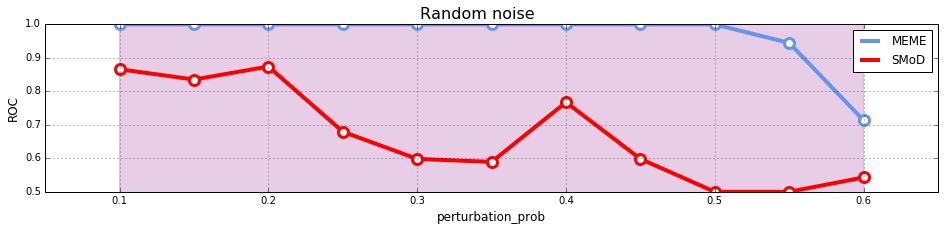

CPU times: user 2min 36s, sys: 13.8 s, total: 2min 50s
Wall time: 5min 31s


In [34]:
%%time

def make_results(n_rep=2):
    for param in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=50,
                                   n_sequences=400,
                                   perturbation_prob=param,
                                   complexity=5,
                                   min_score=4,
                                   min_freq=0.25,
                                   min_cluster_size=5,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   similarity_threshold=.75,
                                   freq_threshold=None,
                                   p_value=1,
                                   regex_th=0.3,
                                   sample_size=200,
                                   std_th=None)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

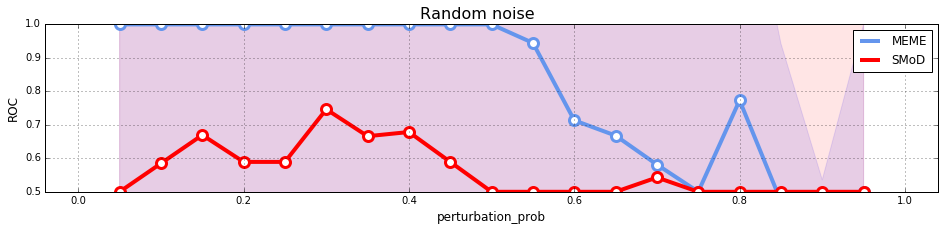

CPU times: user 4min 37s, sys: 23.7 s, total: 5min 1s
Wall time: 10min 46s


In [10]:
%%time

def make_results(n_rep=2):
    for param in [x/float(20) for x in range(1,20)]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=50,
                                   n_sequences=400,
                                   perturbation_prob=param,
                                   complexity=5,
                                   min_score=4,
                                   min_freq=0.25,
                                   min_cluster_size=5,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   similarity_threshold=.75,
                                   freq_threshold=None,
                                   p_value=1,
                                   regex_th=0.3,
                                   sample_size=200,
                                   std_th=None)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

In [ ]:
%%time

def make_results(n_rep=2):
    for param in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=50,
                                   n_sequences=400,
                                   perturbation_prob=param,
                                   complexity=5,
                                   min_score=4,
                                   min_freq=0.25,
                                   min_cluster_size=5,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   similarity_threshold=.75,
                                   freq_threshold=None,
                                   p_value=1,
                                   regex_th=0.3,
                                   sample_size=200,
                                   std_th=None)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

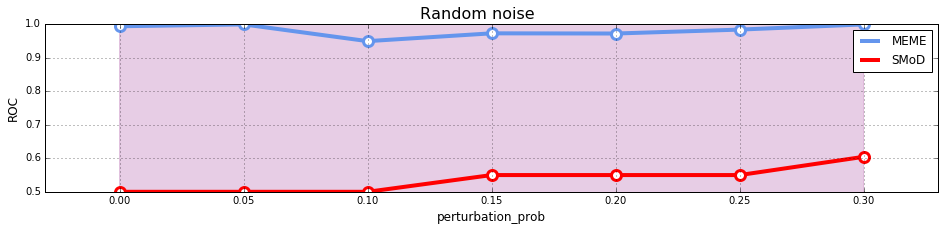

CPU times: user 2min 16s, sys: 12.3 s, total: 2min 29s
Wall time: 9min 13s


In [37]:
%%time

def make_results(n_rep=2):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=3,
                                   sequence_length=60,
                                   n_sequences=600,
                                   perturbation_prob=param,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   similarity_threshold=0.5,
                                   freq_threshold=0.15,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

No motives found by SMoD.
No motives found by SMoD.


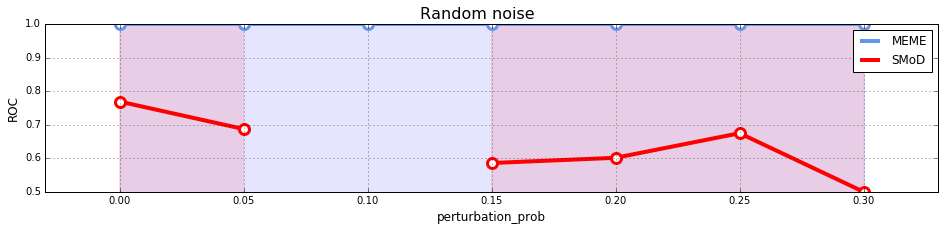

CPU times: user 1min 29s, sys: 9.91 s, total: 1min 38s
Wall time: 4min 52s


In [38]:
%%time

def make_results(n_rep=2):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=500,
                                   perturbation_prob=param,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   similarity_threshold=0.5,
                                   freq_threshold=1,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


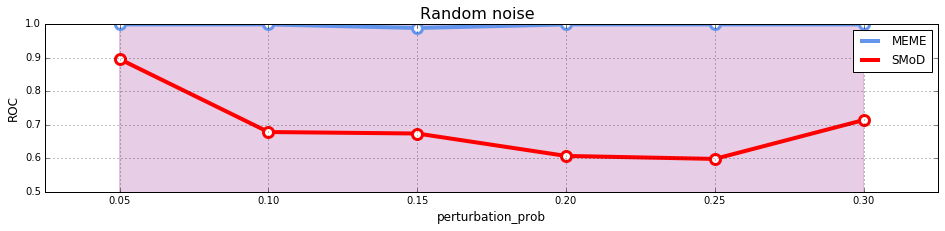

CPU times: user 53.8 s, sys: 4.25 s, total: 58 s
Wall time: 1min 21s


In [9]:
%%time

def make_results(n_rep=2):
    for param in [0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=50,
                                   n_sequences=200,
                                   perturbation_prob=param,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=4,
                                   min_freq=0.25,
                                   min_cluster_size=2,
                                   similarity_threshold=0.80,
                                   freq_threshold=0.20,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

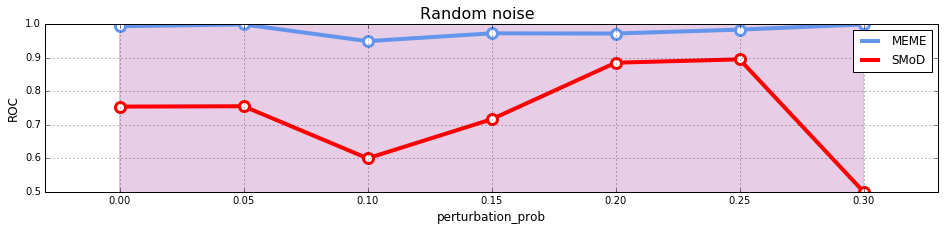

CPU times: user 1min 19s, sys: 4.85 s, total: 1min 23s
Wall time: 4min 20s


In [85]:
%%time

def make_results(n_rep=1):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=3,
                                   sequence_length=60,
                                   n_sequences=600,
                                   perturbation_prob=param,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   similarity_threshold=1,
                                   freq_threshold=0.15,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

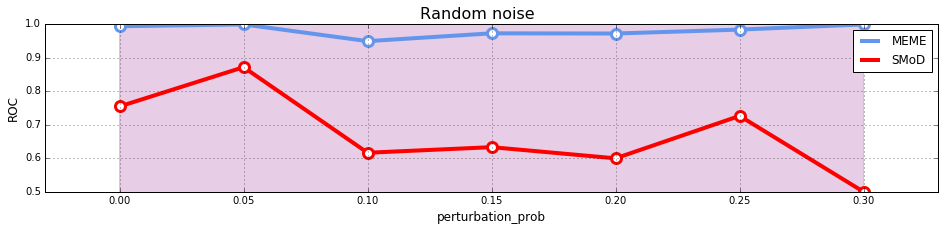

CPU times: user 1min 16s, sys: 4.77 s, total: 1min 20s
Wall time: 4min 19s


In [86]:
%%time

def make_results(n_rep=1):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=3,
                                   sequence_length=60,
                                   n_sequences=600,
                                   perturbation_prob=param,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   similarity_threshold=1,
                                   freq_threshold=0.15,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

In [10]:
#%%time

def make_results(n_rep=5):
    for param in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=50,
                                   n_sequences=400,
                                   perturbation_prob=param,
                                   complexity=5,
                                   min_score=4,
                                   min_freq=0.25,
                                   min_cluster_size=5,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   similarity_threshold=.75,
                                   freq_threshold=None,
                                   p_value=1,
                                   regex_th=0.3,
                                   sample_size=200,
                                   std_th=None)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
#plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

No motives found by SMoD.
No motives found by SMoD.
No motives found by SMoD.


TypeError: unsupported operand type(s) for /: 'list' and 'int'